In [ ]:
# default_exp score

# Score

> Functions related to the score

This notebook contains all functions related to the scoring of peptide-spectrum-matches (PSMS).

Current ToDo here:

- Most of the functions are not very well described yet
- Introductory text to give an overview as well as the relevant papers would be nice

## Filtering

Only matched has dist..

Recall from the search that when having feautres, `raw_idx` refers to the actual index from the raw data. Otherwise it is`query_data`.

For filtering, we have several functions. When applying for a score, we first use `filter_score` and then `filter_precursor`.
`filter_score` is keeping the best score per experimental spectrum. First we rank by score for each `query_idx`. As we have multiple hits for each experimental spectrum from the search we only want to keep the best one.

When performing feature finding, we assign multiple possible features to each experimental spectrum. The idea here is that a spectrum could originate from various precursors. To disentangle these psms we can use the following modes:

* `single`: This mode will only keep one feature per experimental spectrum (the one with the highest score and the closest distance). Each feature can only occur once.
* `multiple`: Allow multiple features per experimental spectrum. Each feature can only occur once.

`filter_precusor` is intended for the case that a precursor (charge + sequence) occurs more than once. Only the one with the highest score will be kept.

In [ ]:
#export
import numpy as np
import pandas as pd
import logging
import alphapept.io

def filter_score(df, mode='multiple'):
    """
    Filter df by score
    TODO: PSMS could still have the same socre when having modifications at multiple positions that are not distinguishable.
    Only keep one.

    """
    df["rank"] = df.groupby("query_idx")["score"].rank("dense", ascending=False).astype("int")
    df = df[df["rank"] == 1]

    # in case two hits have the same score and therfore rank only accept the first one
    df = df.drop_duplicates("query_idx")

    if 'dist' in df.columns:
        df["feature_rank"] = df.groupby("feature_idx")["dist"].rank("dense", ascending=True).astype("int")
        df["raw_rank"] = df.groupby("raw_idx")["score"].rank("dense", ascending=False).astype("int")

        if mode == 'single':
            df_filtered = df[(df["feature_rank"] == 1) & (df["raw_rank"] == 1) ]
            df_filtered = df_filtered.drop_duplicates("raw_idx")

        elif mode == 'multiple':
            df_filtered = df[(df["feature_rank"] == 1)]

        else:
            raise NotImplementedError('Mode {} not implemented yet'.format(mode))

    else:
        df_filtered = df

    # TOD: this needs to be sorted out, for modifications -> What if we have MoxM -> oxMM, this will screw up with the filter sequence part
    return df_filtered

def filter_precursor(df):
    """
    Filter df by precursor
    Allow each precursor only once.

    """
    df["rank_precursor"] = (
        df.groupby("precursor")["score"].rank("dense", ascending=False).astype("int")
    )
    df_filtered = df[df["rank_precursor"] == 1]

    return df_filtered

## Q-Values


In [ ]:
#export
from numba import njit
@njit
def get_q_values(fdr_values):
    """
    Calculate q values from fdr_values
    """
    q_values = np.zeros_like(fdr_values)
    min_q_value = np.max(fdr_values)
    for i in range(len(fdr_values) - 1, -1, -1):
        fdr = fdr_values[i]
        if fdr < min_q_value:
            min_q_value = fdr
        q_values[i] = min_q_value

    return q_values

## FDR

The employed FDR strategy is based on a classical target-decoy competition approach. The procedure works as follows:
1. Consider only the best scoring target or decoy PSM per spectrum. 
2. Sort all PSMs by decreasing scores.
3. Estimate the FDR as #decoys / #targets, where #targets (#decoys) is the number of positive target (decoy) PSMs at a given score threshold t (i.e. PSMs with scores higher than t).
4. Convert the estimated FDR to q-values by selecting the minimum FDR at which the identification could be made, i.e. the lowest score threshold t that could be set to include an identification without increasing the number of false positives.
5. Report the set of target PSMs with q-values smaller or equal to the selected `fdr_level`.

Informative literature describing and discussing different FDR estimation approaches for shotgun proteomics can be found here (the implemented strategy in alphapept is referred to as T-TDC in this article):
> Keich, Uri et al. "Improved False Discovery Rate Estimation Procedure for Shotgun Proteomics." Journal of proteome research vol. 14,8 (2015): 3148-61. <https://pubs.acs.org/doi/10.1021/acs.jproteome.5b00081>


In [ ]:
#export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def cut_fdr(df, fdr_level=0.01, plot=True):
    """
    Cuts a dataframe with a given fdr level

    Args:
        fdr_level: fdr level that should be used
        plot: flag to enable plot

    Returns:
        cutoff: df with psms within fdr
        cutoff_value: numerical value of score cutoff

    Raises:

    """

    df["target"] = ~df["decoy"]

    df = df.sort_values(by=["score","decoy"], ascending=False)
    df = df.reset_index()

    df["target_cum"] = np.cumsum(df["target"])
    df["decoys_cum"] = np.cumsum(df["decoy"])

    df["fdr"] = df["decoys_cum"] / df["target_cum"]
    df["q_value"] = get_q_values(df["fdr"].values)

    last_q_value = df["q_value"].iloc[-1]
    first_q_value = df["q_value"].iloc[0]

    if last_q_value <= fdr_level:
        logging.info('Last q_value {:.3f} of dataset is smaller than fdr_level {:.3f}'.format(last_q_value, fdr_level))
        cutoff_index = len(df)-1

    elif first_q_value >= fdr_level:
        logging.info('First q_value {:.3f} of dataset is larger than fdr_level {:.3f}'.format(last_q_value, fdr_level))
        cutoff_index = 0

    else:
        cutoff_index = df[df["q_value"].gt(fdr_level)].index[0] - 1

    cutoff_value = df.loc[cutoff_index]["score"]
    cutoff = df[df["score"] >= cutoff_value]

    targets = df.loc[cutoff_index, "target_cum"]
    decoy = df.loc[cutoff_index, "decoys_cum"]

    fdr = df.loc[cutoff_index, "fdr"]


    logging.info(
        "{:,} target ({:,} decoy) of {} PSM. fdr {:.6f} for a cutoff of {:.2f} ".format(
            targets, decoy, len(df), fdr, cutoff_value
        )
    )

    if plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 5))
        plt.plot(df["score"], df["fdr"])
        plt.axhline(0.01, color="k", linestyle="--")

        plt.axvline(cutoff_value, color="r", linestyle="--")
        plt.title("fdr vs Cutoff value")
        plt.xlabel("Score")
        plt.ylabel("fdr")
        # plt.savefig('fdr.png')
        plt.show()

        bins = np.linspace(np.min(df["score"]), np.max(df["score"]), 100)
        plt.figure(figsize=(10, 5))
        sns.distplot(df[df["decoy"]]["score"].values, label="decoy", bins=bins)
        sns.distplot(df[~df["decoy"]]["score"].values, label="target", bins=bins)
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.title("Score vs Class")
        plt.legend()
        plt.show()

    cutoff = cutoff.reset_index(drop=True)
    return cutoff_value, cutoff

In [ ]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulateTargetDecoyScores(n, target_mu=4.0, stdev=1.0, pi0=0.5):
    decoys = np.random.normal(loc=0.0, scale=stdev, size=n)
    false_targets = np.random.normal(loc=0.0, scale=stdev, size=int(np.round(n*pi0)))
    true_targets = np.random.normal(loc=target_mu, scale=stdev, size=int(np.round(n*(1-pi0))))
    
    df = pd.DataFrame({
        'TD':np.append(np.append(np.repeat('TT',len(true_targets)),np.repeat('FT',len(false_targets))),np.repeat('D',len(decoys))),
        'decoy':np.append(np.repeat(False,len(true_targets)+len(false_targets)), np.repeat(True,len(decoys))),
        'score':np.append(np.append(true_targets,false_targets),decoys),
        'sequence':np.append(np.arange(0,n),np.arange(0,n)),
        'protein':np.append(np.arange(0,n),np.arange(0,n))})
    
    return df

def simulateProteinLevelTargetDecoyScores(n, target_mu=4.0, stdev=1.0, pi0=0.5, plot=True):
    idx = np.arange(0,n)

    protein_size = np.random.poisson(lam=3.0, size=n) + 1
    
    if plot:
        plt.hist(protein_size)
        plt.title("Number of peptides per protein")
        plt.xlabel("Number of peptides per protein")
        plt.ylabel("Count")
        plt.show()

    TT_protein_size = protein_size[idx[0:int(np.round(1-(n*pi0)))]]
    FT_protein_size = protein_size[idx[int(np.round(1-(n*pi0))):n]]
    D_protein_size = protein_size

    true_targets = np.random.normal(loc=target_mu, scale=stdev, size=sum(TT_protein_size))
    false_targets = np.random.normal(loc=0.0, scale=stdev, size=sum(FT_protein_size))
    decoys = np.random.normal(loc=0.0, scale=stdev, size=sum(D_protein_size))

    D_proteins = np.repeat(idx,D_protein_size)
    TT_proteins = np.repeat(idx[0:int(np.round(1-(n*pi0)))],TT_protein_size)
    FT_proteins = np.repeat(idx[int(np.round(1-(n*pi0))):n],FT_protein_size)

    df = pd.DataFrame({
        'TD':np.append(np.append(np.repeat('TT',len(TT_proteins)),np.repeat('FT',len(FT_proteins))),np.repeat('D',len(D_proteins))),
        'decoy':np.append(np.repeat(False,len(TT_proteins)+len(FT_proteins)), np.repeat(True,len(D_proteins))),
        'score':np.append(np.append(true_targets,false_targets),decoys),
        'sequence':np.append(np.arange(0,sum(protein_size)),np.arange(0,sum(protein_size))),
        'protein':np.append(np.append(TT_proteins,FT_proteins),D_proteins)})

    return df

def plot_score_hist(df, analyte_level='sequence'):
    
    if analyte_level=='protein':
        df = df.sort_values(by=['protein','score'], ascending=False)
        df = df.drop_duplicates(subset='protein', keep="first")
    
    decoys=df[df.decoy].score.values
    false_targets= df[df.TD == 'FT'].score.values
    true_targets= df[df.TD == 'TT'].score.values
    
    minS = int(np.round(np.min(np.append(decoys, np.append(false_targets, true_targets)))))
    maxS = int(np.round(np.max(np.append(decoys, np.append(false_targets, true_targets)))))
    
    plt.hist(false_targets, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='mid', label='false targets')
    plt.hist(true_targets, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='mid', label='true targets')
    plt.hist(decoys, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='left', label='decoys')
    plt.legend(loc='best')
    plt.title("score histogram")
    plt.xlabel("score")
    plt.ylabel("count")
    plt.xlim(-5,10)
    plt.show()

def score_TDcompetition(df):
    td_dataframe = pd.DataFrame({'T':df[~df.decoy].score.values, 'D':df[df.decoy].score.values, 'label':df[~df.decoy].TD.values})
    td_dataframe['win'] = td_dataframe.apply(lambda x: 'T' if x['T'] > x['D'] else 'D', axis = 1)

    target_in = np.where(td_dataframe.win=='T')
    decoy_in = np.where(td_dataframe.win=='D')

    T_df = df[(~df.decoy) & (np.isin(df.sequence, target_in))]
    D_df = df[(df.decoy) & (np.isin(df.sequence, decoy_in))]
    
    df = T_df.append(D_df)
    
    return df


def get_simulated_stat_rates(df, TDcompetition = False, analyte_level='sequence', df_ini = None):
    alpha = np.arange(0.002,1,0.002)
    stat_rates = pd.DataFrame(columns=['alpha','TP','FP','TN','FN','TPR','FPR','FDR','FNR','ACC'])

    if analyte_level=='protein':
        df = df.drop_duplicates(subset='protein', keep="first")
        
    for idx in range(len(alpha)):
        sig = df[df.q_value <= alpha[idx]]
        not_sig = df[df.q_value > alpha[idx]]

        TP = len(sig[sig.TD == 'TT'][analyte_level].unique())
        FP = len(sig[sig.TD == 'FT'][analyte_level].unique())
        TN = len(not_sig[not_sig.TD == 'FT'][analyte_level].unique())
        FN = len(not_sig[not_sig.TD == 'TT'][analyte_level].unique())
        
        if TDcompetition:
            TN = TN + (len(df_ini[df_ini.TD == 'FT'][analyte_level].unique()) - len(df[df.TD == 'FT'][analyte_level].unique()))
            FN = FN + (len(df_ini[df_ini.TD == 'TT'][analyte_level].unique()) - len(df[df.TD == 'TT'][analyte_level].unique()))


        TPR = TP/(TP+FN) 
        FPR = FP/(FP+TN) 
        if (FP+TP)==0:
            FDR = 0
        else:
            FDR = FP/(FP+TP)
        FNR = FN/(FN+TP)

        ACC = (TP+TN)/(TP+TN+FP+FN)

        stat_rates.loc[idx] = [alpha[idx], TP, FP, TN, FN, TPR, FPR, FDR, FNR, ACC] 
    
    border = 0.1
    
    plt.plot([-1,2], [-1,2], linestyle="--", color='red')
    plt.scatter(stat_rates.alpha, stat_rates.FDR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-border,1+border)
    plt.title("decoy vs. true FDR")
    plt.xlabel("decoy FDR")
    plt.ylabel("true FDR")
    plt.show()
    
    plt.plot([-1,1], [-1,1], linestyle="--", color='red')
    plt.scatter(stat_rates.alpha, stat_rates.FDR)
    plt.ylim(0-(0.01),0.1+(0.01))
    plt.xlim(0-(0.01),0.1+(0.01))
    plt.title("decoy vs. true FDR (zoom)")
    plt.xlabel("decoy FDR")
    plt.ylabel("true FDR")
    plt.show()
    
    plt.plot([-1,2], [1,1], linestyle="--", color='red')
    plt.scatter(stat_rates.FPR, stat_rates.TPR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-border,1+border)
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    plt.plot([-1,2], [1,1], linestyle="--", color='red')
    plt.scatter(stat_rates.FPR, stat_rates.TPR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-0.01,0.1+0.01)
    plt.title("ROC curve (zoom)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    return stat_rates

def plot_qvalue_vs_fdr(df):
    plt.plot(df.fdr, df.target_cum, label='FDR')
    plt.plot(df.q_value, df.target_cum, label='q-value')
    plt.xlim(0-0.0001,0.005)
    plt.ylim(0-100,7000)
    plt.legend(loc='best')
    plt.title("Difference between q-value and FDR")
    plt.xlabel("q-value / FDR")
    plt.ylabel("Cummulative number of accepted targets")
    plt.show()

In [ ]:
#hide
TD = simulateTargetDecoyScores(n=50000, pi0=0.8, target_mu=3.5)
TDC = score_TDcompetition(TD)

Simulation of random scores for 50'000 measurements (corresponding to spectra). Simulated are decoys, true targets and false targets. We assume a false traget raio (pi0) of 0.8 and a mean score difference of 3.5.

Simulated score distribution for a separate target and decoy database search:

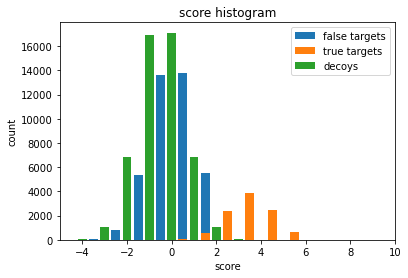

In [ ]:
#hide
plot_score_hist(TD, analyte_level='sequence')

Simulated score distribution for a corresponding concatinated target-decoy database search with target-decoy-competition:

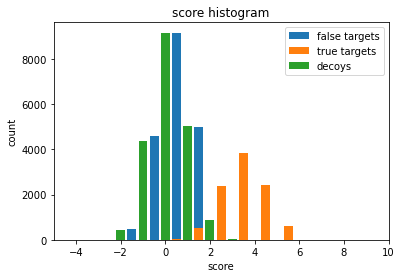

In [ ]:
#hide
plot_score_hist(TDC, analyte_level='sequence')

Application of the `cut_fdr` function to the simulated target-decoy competition dataset saved in `TDC`:

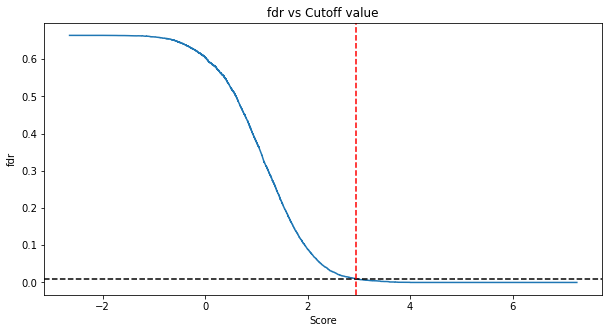

C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


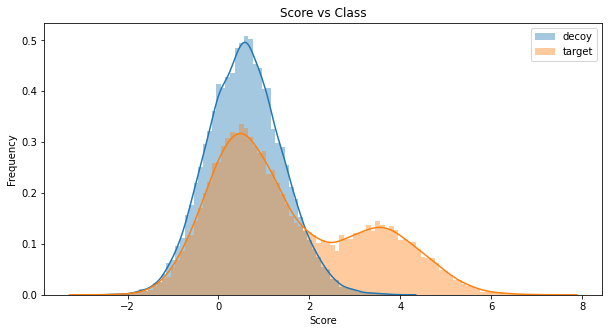

In [ ]:
cval, cut_TDC = cut_fdr(TDC, fdr_level=0.01)

Evaluation of the FDR estimated by the target-decoy approach versus the true FDR confirms accurate FDR estimation by our approach. The true FDR is capped by the selected fraction of false targets (pi0 = 0.8) and by the effect of target decoy competition. Similarly, the true positive rate (TPR) is limited by the effect of target decoy competition and can only reach 1 in cases where not a single decoy scores higher than a true target.

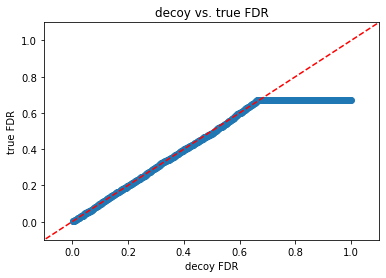

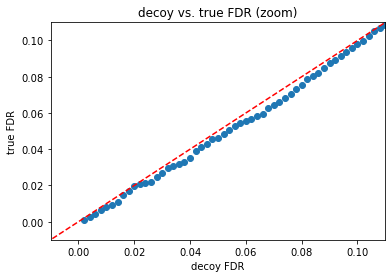

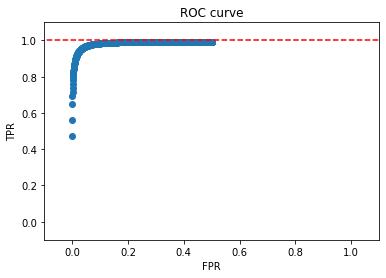

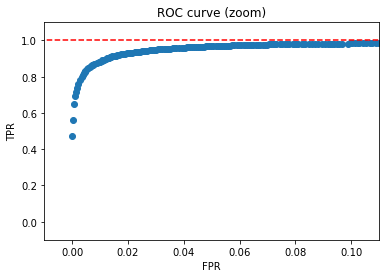

In [ ]:
# hide
cval_, cut_TDC_ = cut_fdr(TDC, fdr_level=100, plot=False)
stat = get_simulated_stat_rates(cut_TDC_, TDcompetition = True, analyte_level='sequence', df_ini = TD)

The following figure illustrates the difference between `fdr` and `q_value`.

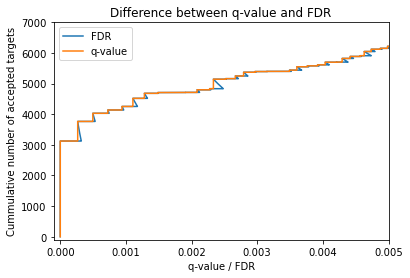

In [ ]:
# hide
plot_qvalue_vs_fdr(cut_TDC_)

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Global FDR

The `cut_global_fdr` function has two specific applications:
1. **Estimate q-values on the peptide and protein level** <br/>
The concept here is based on selecting the best scoring precursor per peptide (or protein) to then estimate the FDR by target-decoy competition using the `cut_fdr` function.
2. **Estimate q-values across an entire dataset on either precursor, peptide or protein level** <br/>
The concept here is based on selecting the best scoring precursor, peptide or protein signal across an entire dataset to then estimate the FDR by target-decoy competition using the `cut_fdr` function.

This strategy was extensively tested and discussed in the following publications:
> Nesvizhskii, Alexey I. "A survey of computational methods and error rate estimation procedures for peptide and protein identification in shotgun proteomics." Journal of proteomics vol. 73,11 (2010): 2092-123. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2956504/> 

> Savitski, Mikhail M et al. "A Scalable Approach for Protein False Discovery Rate Estimation in Large Proteomic Data Sets." Molecular & cellular proteomics : MCP vol. 14,9 (2015): 2394-404. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4563723/>

> The, Matthew et al. "Fast and Accurate Protein False Discovery Rates on Large-Scale Proteomics Data Sets with Percolator 3.0." Journal of the American Society for Mass Spectrometry vol. 27,11 (2016): 1719-1727. <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5059416/>

> Gupta, Nitin, and Pavel A Pevzner. "False discovery rates of protein identifications: a strike against the two-peptide rule." Journal of proteome research vol. 8,9 (2009): 4173-81. 
<https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3398614/>

In [ ]:
#export

def cut_global_fdr(data, analyte_level='sequence', fdr_level=0.01, plot=True, **kwargs):
    """
    Function to estimate and filter by global peptide or protein fdr

    """
    logging.info('Global FDR on {}'.format(analyte_level))
    data_sub = data[[analyte_level,'score','decoy']]
    data_sub_unique = data_sub.groupby([analyte_level,'decoy'], as_index=False).agg({"score": "max"})

    analyte_levels = ['precursor', 'sequence', 'protein']

    if analyte_level in analyte_levels:
        agg_score = data_sub_unique.groupby([analyte_level,'decoy'])['score'].max().reset_index()
    else:
        raise Exception('analyte_level should be either sequence or protein. The selected analyte_level was: {}'.format(analyte_level))

    agg_cval, agg_cutoff = cut_fdr(agg_score, fdr_level=fdr_level, plot=plot)

    agg_report = pd.merge(data,
                          agg_cutoff,
                          how = 'inner',
                          on = [analyte_level,'decoy'],
                          suffixes=('', '_'+analyte_level),
                          validate="many_to_one")
    return agg_report

Similar to the sequence level simulations we can simulatae score distributions for peptides beloning to proteins. In our simulation we assumed a poisson distribution for the number of peptides for each protein centered at 4 peptides. 

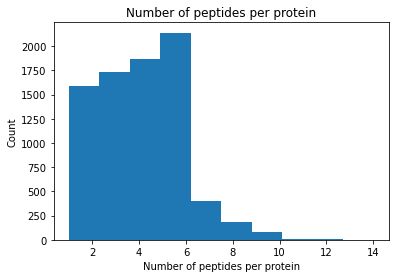

In [ ]:
#hide
TD_prot = simulateProteinLevelTargetDecoyScores(n=8000, pi0=0.8, target_mu=3.5)

TDC_prot = score_TDcompetition(TD_prot)


Application of the `cut_global_fdr` function to the simulated protein-level target-decoy competition dataset saved in `TDC_prot`:

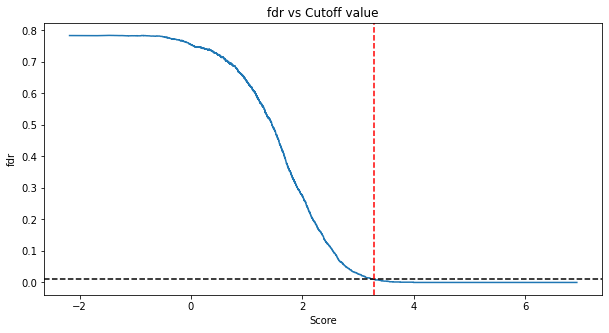

C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


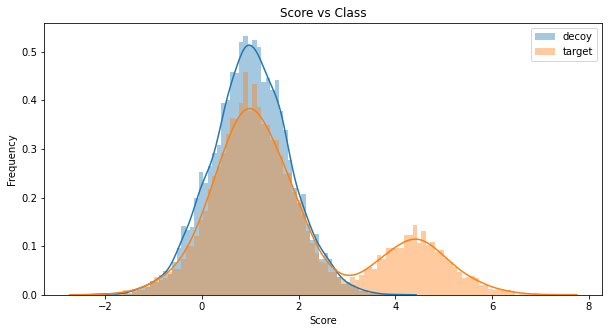

In [ ]:
cut_TDC_prot = cut_global_fdr(TDC_prot, fdr_level=0.01, analyte_level='protein')

Evaluation of the protein-level FDR estimated by the target-decoy approach versus the true FDR confirms accurate FDR estimation by our approach:

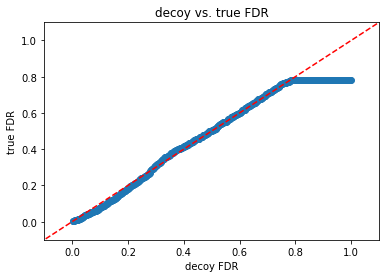

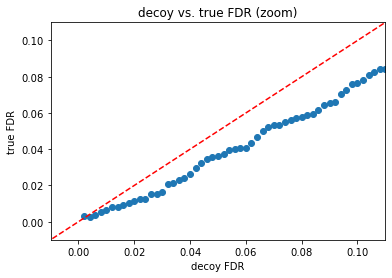

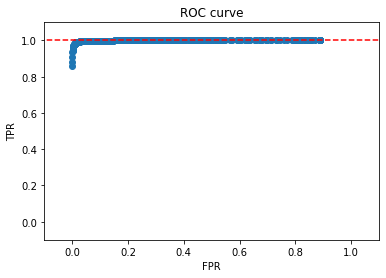

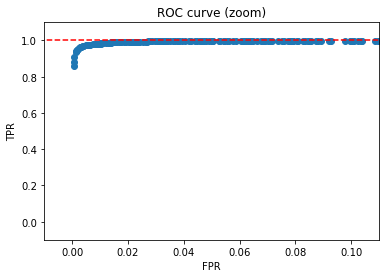

In [ ]:
#hide
cut_TDC_prot_ = cut_global_fdr(TDC_prot, fdr_level=100, analyte_level='protein', plot=False)
stat_prot = get_simulated_stat_rates(cut_TDC_prot_, TDcompetition = True, analyte_level='protein', df_ini = TD_prot)

Investigating the peptide-level statistics after protein-level FDR filtering shows a conservative pattern.

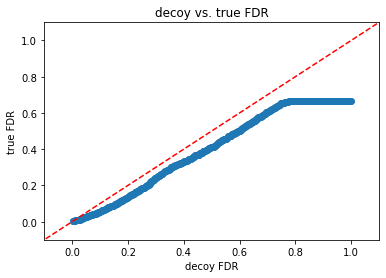

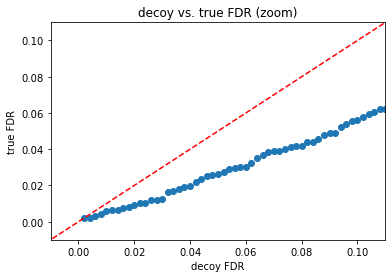

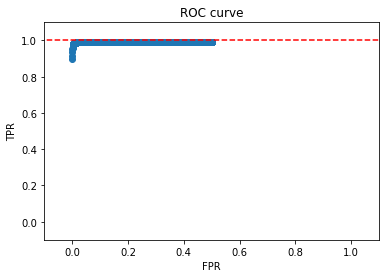

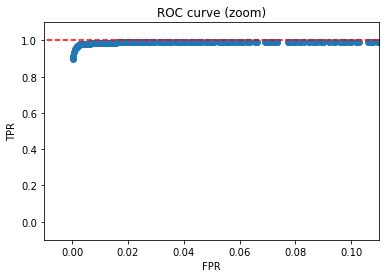

In [ ]:
#hide
stat_prot = get_simulated_stat_rates(cut_TDC_prot_, TDcompetition = True, analyte_level='sequence', df_ini = TD_prot)

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Scoring

### X!tandem scoring

* `get_x_tandem_score` performs scoring of PSMs according to the X!tandem strategy:

* `score_x_tandem` first calls `get_x_tandem_score` and and subsequently applies the `cut_fdr` function to filter PSMs at the specified `fdr_level`.

> X!Tandem, Craig,R. and Beavis,R.C. (2003) Rapid Commun. Mass Spectrom., 17, 2310-2316

In [ ]:
#export

import networkx as nx

def get_x_tandem_score(df):

    b = df['b_hits'].astype('int').apply(lambda x: np.math.factorial(x)).values
    y = df['y_hits'].astype('int').apply(lambda x: np.math.factorial(x)).values
    x_tandem = np.log(b.astype('float')*y.astype('float')*df['matched_int'].values)

    x_tandem[x_tandem==-np.inf] = 0

    return x_tandem

def score_x_tandem(df, fdr_level = 0.01, plot = True, **kwargs):
    logging.info('Scoring using X-Tandem')
    df['score'] = get_x_tandem_score(df)
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    df = filter_precursor(df)
    cval, cutoff = cut_fdr(df, fdr_level, plot)

    return cutoff

def filter_with_x_tandem(df, fdr_level = 0.01):
    """
    Filters a dataframe using an x_tandem score
    """
    logging.info('Filter df with x_tandem score')

    df['score'] = get_x_tandem_score(df)
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    df = filter_precursor(df)

    return df

In [ ]:
#hide

def test_get_x_tandem_score():
    y_hits = np.array([1,2,3,0])
    b_hits = np.array([0,1,2,1])
    matched_int = np.array([1000,1000,1000,1000])
    df = pd.DataFrame({'y_hits':y_hits,'b_hits':b_hits,'matched_int':matched_int})
    np.testing.assert_almost_equal(get_x_tandem_score(df), np.array([6.90775528, 7.60090246, 9.39266193, 6.90775528]))

test_get_x_tandem_score()

def test_score_x_tandem():
    y_hits = np.array([1,2,3,0])
    b_hits = np.array([0,1,2,1])
    matched_int = np.array([1000,1000,1000,1000])
    sequence = np.array(['A','A','B','C_decoy'])
    precursor = np.array(['A1','A1','B','C_decoy'])
    query_idx = np.array([1,2,3,4])
    df = pd.DataFrame({'y_hits':y_hits,'b_hits':b_hits,'matched_int':matched_int,
                      'sequence':sequence,'precursor':precursor,'query_idx':query_idx})
    res = score_x_tandem(df, fdr_level=1, plot=False)
    assert all(res.precursor == ['B','A1','C_decoy'])
    assert all(res.q_value == [0,0,0.5])

test_score_x_tandem()

### Score and filter PSMs by any specified score

`score_psms` uses the specified `score` and applies the `cut_fdr` function to filter PSMs at the specified `fdr_level`. `filter_score` and `filter_precursor` are applied to only report the best PSM per acquired spectrum and the best signal per precursor (i.e. sequence + charge combination).

In [ ]:
#export

def score_psms(df, score = 'y_hits', fdr_level = 0.01, plot = True, **kwargs):
    if score in df.columns:
        df['score'] = df[score]
    else:
        raise ValueError("The specified 'score' {} is not available in 'df'.".format(score))
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    df = filter_precursor(df)
    cval, cutoff = cut_fdr(df, fdr_level, plot)

    return cutoff

In [ ]:
#hide

def test_score_psms():
    y_hits = np.array([1,2,3,0])
    b_hits = np.array([0,1,2,1])
    matched_int = np.array([1000,1000,1000,1000])
    sequence = np.array(['A','A','B','C_decoy'])
    precursor = np.array(['A1','A1','B','C_decoy'])
    query_idx = np.array([1,2,3,4])
    df = pd.DataFrame({'y_hits':y_hits,'b_hits':b_hits,'matched_int':matched_int,
                      'sequence':sequence,'precursor':precursor,'query_idx':query_idx})
    
    res = score_psms(df, fdr_level=1, plot=False)
    assert all(res.precursor == ['B','A1','C_decoy'])
    assert all(res.q_value == [0,0,0.5])
    
    res = score_psms(df, score='b_hits', fdr_level=1, plot=False)
    assert all(res.precursor == ['B','C_decoy','A1'])
    assert all(res.q_value == [0,0.5,0.5])

test_score_x_tandem()

## Machine learning based scoring of PSMs

* `get_ML_features` extracts additional scoring metrics for the machine learning, including the number of amino acids per precursor, the number of missed cleavages and the logarithmic number of times the same peptide occurs in the set of PSMs

* `train_RF` trains a random forest classifier for scoring all PSMs. For this, we use the scikit-learn library.
    * First, a machine learning pipeline is created including the sklearn `StandardScaler` and `RandomForestClassifier`. The `StandardScaler` is used to standardize all features by removing the mean and scaling to unit variance. For details on the `RandomForestClassifier` see: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>.
    * Next, a grid search is initialized for testing the hyperparameter space (`max_depth` and `max_leaf_nodes`) of the random forest classifier by a 5-fold cross-validation using `GridSearchCV`.
    * To train the classifier, we first select a suitable set of PSMSs. This is achieved by an initial scoring and FDR estimation of the input PSMs based on the `ini_score`. Only targets below the `train_fdr_level` cutoff are considered for training the classifier. To ensure a balanced dataset for training (i.e. same number of targets and decoys), the number of PSMs per category is selected to be the minimum of either the number of high scoring targets below the `train_fdr_level` cutoff or the overall number of decoys among the PSMs. `min_train` specifies the minimum number of targets and decoys that should be available. 
    * Once a balanced set of PSMs is established, the PSMs are split into a training and test set accoring to the `test_size` argument using `train_test_split` from sklearn while ensuring the PSMs are split in a stratified fashion (i.e. equal number of targets and decoys in both the training and test sets).
    * The grid search and training of the random forest classifier is performed on the training set of PSMs. The `GridSearchCV` returns the classifier which performed best across all cross-validation hold-out sets according to the `scoring` function (classification *'accuracy'* is set as default score). The grid search is parallelize dinto `n_jobs`.
    * Next, the trained classifier is applied to the testing set of PSMs and the test score is reported. 
    * If `plot` is enabled, a figure illustrating the weights of each feature is produced.
    * Finally the function returns the trained random forest classifier for subsequent application to the entire set of PSMs or for transfering to a different dataset. 

* `score_ML` applies a classifier trained by `train_RF` to a complete set of PSMs. It calls the `cut_fdr` function and filters for the specified `fdr_level`. `filter_score` and `filter_precursor` are applied to only report the best PSM per acquired spectrum and the best signal per precursor (i.e. sequence + charge combination).

In [ ]:
#export

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from alphapept.fasta import count_missed_cleavages, count_internal_cleavages


def get_ML_features(df, protease='trypsin', **kwargs):
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df['abs_delta_m_ppm'] = np.abs(df['delta_m_ppm'])
    df['naked_sequence'] = df['sequence'].str.replace('[a-z]|_', '')
    df['n_AA']= df['naked_sequence'].str.len()
    df['matched_ion_fraction'] = df['hits']/(2*df['n_AA'])

    #df['decoy_reversed_seq'] = df['naked_sequence']
    #df.loc[df['decoy'] == True, 'decoy_reversed_seq'] = df['decoy_reversed_seq'].apply(lambda x: x[::-1])
    df['n_missed'] = df['naked_sequence'].apply(lambda x: count_missed_cleavages(x, protease))
    df['n_internal'] = df['naked_sequence'].apply(lambda x: count_internal_cleavages(x, protease))
    #df = df.drop(columns=['decoy_reversed_seq'])

    mz_bin, mz_count = np.unique(np.floor(df.mz/100), return_counts=True)
    mz_count = np.log(mz_count)
    df['ln_mz_range'] = df['mz'].apply(lambda x: mz_count[mz_bin == np.floor(x/100)])
    df = df.astype({"ln_mz_range": float})

    df['charge_'] = df['charge']
    df = pd.get_dummies(df, columns=['charge'])
    df = df.rename(columns={'charge_': 'charge'})

    count_seq = df.groupby('naked_sequence')['naked_sequence'].count()
    df['ln_sequence'] = np.log(count_seq[df['naked_sequence']].values)
    df['x_tandem'] = get_x_tandem_score(df)

    return df

def train_RF(df,
             features = ['y_hits','b_hits','matched_int',
                         'delta_m_ppm','abs_delta_m_ppm',
                        'charge_2.0','charge_3.0','charge_4.0','charge_5.0',
                        'n_AA','n_missed','n_internal','ln_sequence','x_tandem',
                        'db_mass_density','db_weighted_mass_density',
                        'db_mass_density_digit','db_weighted_mass_density_digit',
                        'hits','matched_ion_fraction','ln_mz_range'],
             train_fdr_level = 0.1,
             ini_score = 'y_hits',
             min_train = 5000,
             test_size = 0.8,
             max_depth = [5,25,50],
             max_leaf_nodes = [150,200,250],
             n_jobs=3,
             scoring='accuracy',
             plot = True,
             random_state = 42,
             **kwargs):

    # Setup ML pipeline
    scaler = StandardScaler()
    rfc = RandomForestClassifier(random_state=random_state) # class_weight={False:1,True:5},
    ## Initiate scaling + classification pipeline
    pipeline = Pipeline([('scaler', scaler), ('clf', rfc)])
    parameters = {'clf__max_depth':(max_depth), 'clf__max_leaf_nodes': (max_leaf_nodes)}
    ## Setup grid search framework for parameter selection and internal cross validation
    cv = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring=scoring,
                     verbose=0,return_train_score=True,n_jobs=n_jobs)

    # Prepare target and decoy df
    df['decoy'] = df['sequence'].str[-1].str.islower()
    df['target'] = ~df['decoy']
    df['score'] = df[ini_score]
    dfT = df[~df.decoy]
    dfD = df[df.decoy]

    # Select high scoring targets (<= train_fdr_level)
    df_prescore = filter_score(df)
    df_prescore = filter_precursor(df_prescore)
    scored = cut_fdr(df_prescore, fdr_level = train_fdr_level, plot=False)[1]
    highT = scored[scored.decoy==False]
    dfT_high = dfT[dfT['query_idx'].isin(highT.query_idx)]
    dfT_high = dfT_high[dfT_high['db_idx'].isin(highT.db_idx)]

    # Determine the number of psms for semi-supervised learning
    n_train = int(dfT_high.shape[0])
    if dfD.shape[0] < n_train:
        n_train = int(dfD.shape[0])
        logging.info("The total number of available decoys is lower than the initial set of high scoring targets.")
    if n_train < min_train:
        raise ValueError("There are fewer high scoring targets or decoys than required by 'min_train'.")

    # Subset the targets and decoys datasets to result in a balanced dataset
    df_training = dfT_high.sample(n=n_train, random_state=random_state).append(dfD.sample(n=n_train, random_state=random_state))

    # Select training and test sets
    X = df_training[features]
    y = df_training['target'].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=test_size, random_state=random_state, stratify=y.values)

    # Train the classifier on the training set via 5-fold cross-validation and subsequently test on the test set
    logging.info('Training & cross-validation on {} targets and {} decoys'.format(np.sum(y_train),X_train.shape[0]-np.sum(y_train)))
    cv.fit(X_train,y_train)

    logging.info('The best parameters selected by 5-fold cross-validation were {}'.format(cv.best_params_))
    logging.info('The train {} was {}'.format(scoring, cv.score(X_train, y_train)))
    logging.info('Testing on {} targets and {} decoys'.format(np.sum(y_test),X_test.shape[0]-np.sum(y_test)))
    logging.info('The test {} was {}'.format(scoring, cv.score(X_test, y_test)))

    # Inspect feature importances
    if plot:
        feature_importances=cv.best_estimator_.named_steps['clf'].feature_importances_
        indices = np.argsort(feature_importances)[::-1][:40]
        g = sns.barplot(y=X.columns[indices][:40],
                        x = feature_importances[indices][:40],
                        orient='h', palette='RdBu')
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title("Feature importance")
        plt.show()

    return cv

def score_ML(df,
             trained_classifier,
             features = ['y_hits','b_hits','matched_int',
                         'delta_m_ppm','abs_delta_m_ppm',
                        'charge_2.0','charge_3.0','charge_4.0','charge_5.0',
                        'n_AA','n_missed','n_internal','ln_sequence','x_tandem',
                        'db_mass_density','db_weighted_mass_density',
                        'db_mass_density_digit','db_weighted_mass_density_digit',
                        'hits','matched_ion_fraction','ln_mz_range'],
            fdr_level = 0.01,
            plot=True,
             **kwargs):
    logging.info('Scoring using Machine Learning')
    # Apply the classifier to the entire dataset
    df_new = df.copy()
    df_new['score'] = trained_classifier.predict_proba(df_new[features])[:,1]
    df_new = filter_score(df_new)
    df_new = filter_precursor(df_new)
    cval, cutoff = cut_fdr(df_new, fdr_level, plot)

    return cutoff


def filter_with_ML(df,
             trained_classifier,
             features = ['y_hits','b_hits','matched_int',
                         'delta_m_ppm','abs_delta_m_ppm',
                        'charge_2.0','charge_3.0','charge_4.0','charge_5.0',
                        'n_AA','n_missed','n_internal','ln_sequence','x_tandem',
                        'db_mass_density','db_weighted_mass_density',
                        'db_mass_density_digit','db_weighted_mass_density_digit',
                        'hits','matched_ion_fraction','ln_mz_range'],
            fdr_level = 0.01,
            plot=True,
             **kwargs):

    """
    Filters a dataframe using ML
    """
    logging.info('Filter df with x_tandem score')
    # Apply the classifier to the entire dataset
    df_new = df.copy()
    df_new['score'] = trained_classifier.predict_proba(df_new[features])[:,1]
    df_new = filter_score(df_new)
    df_new = filter_precursor(df_new)

    return df_new

## Protein grouping

For protein grouping, we implement a razor approach. Here, we check whether a protein has unique PSMs, meaning that the peptide can only belong to one protein. For all ambiguous proteins, were PSMs could be shared between multiple proteins, we employ the razor-approach, which is implemented with the networkx-package.

We create a network and add all connections between the peptides and proteins. Then, we extract all connected components, referring to all peptides and proteins that are connected. For a cluster of connected components, we then iterate over all proteins and count the number of peptides that are connected to the particular protein. The protein with the most peptides will then be the razor protein. We remove this protein and the respective peptides and continue with the extraction from the cluster until no more peptides are present.

For efficient implementation, the proteins and peptides are encoded as indexes. To distinguish proteins from peptides, proteins are have a leading 'p'.

In [ ]:
#export
import networkx as nx
def get_protein_groups(data, pept_dict, fasta_dict, callback = None, **kwargs):
    """
    Function to perform protein grouping by razor approach
    ToDo: implement callback for solving
    Each protein is indicated with a p -> protein index
    """
    G=nx.Graph()

    found_proteins = {}

    for i in range(len(data)):
        line = data.iloc[i]
        seq = line['sequence']
        score = line['score']
        if seq in pept_dict:
            proteins = pept_dict[seq]
            if len(proteins) > 1:
                for protein in proteins:
                    G.add_edge(str(i), 'p'+str(protein), score=score)
            else: #if there is only one PSM just add to this protein
                if 'p'+str(proteins[0]) in found_proteins.keys():
                    found_proteins['p'+str(proteins[0])] = found_proteins['p'+str(proteins[0])] + [str(i)]
                else:
                    found_proteins['p'+str(proteins[0])] = [str(i)]

        if callback:
            callback((i+1)/len(data))

    logging.info('A total of {:,} proteins with unique PSMs found'.format(len(found_proteins)))

    connected_groups = np.array([list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)], dtype=object)
    n_groups = len(connected_groups)


    logging.info('A total of {} ambigious proteins'.format(len(connected_groups)))

    #Solving with razor:
    found_proteins_razor = {}
    for a in connected_groups:
        H = G.subgraph(a)

        shared_proteins = list(np.array(a)[np.array(list(i[0] == 'p' for i in a))])

        removed = []

        while len(shared_proteins) > 0:

            neighbors_list = []

            for node in shared_proteins:
                neighbors = list(H.neighbors(node))
                n_neigbhors = len(neighbors)

                if node in G:
                    if node in found_proteins.keys():
                        n_neigbhors+= len(found_proteins[node])

                neighbors_list.append((n_neigbhors, node, neighbors))

            neighbors_list.sort()

            #Remove the last entry:

            count, node, psms = neighbors_list[-1]

            shared_proteins.remove(node)

            psms = [_ for _ in psms if _ not in removed]

            removed += psms

            found_proteins_razor[node] = psms

    #Put back in Df
    report = data.copy()
    report['protein'] = ''
    report['protein_group'] = ''

    for protein_str in found_proteins.keys():
        protein = int(protein_str[1:])
        indexes = [int(_) for _ in found_proteins[protein_str]]
        report.loc[indexes, 'protein'] = fasta_dict[protein]['name']
        report.loc[indexes, 'protein_group'] = fasta_dict[protein]['name']

    report['razor'] = False
    for protein_str in found_proteins_razor.keys():
        protein = int(protein_str[1:])
        indexes = [int(_) for _ in found_proteins_razor[protein_str]]

        report.loc[indexes, 'protein'] = fasta_dict[protein]['name']
        report.loc[indexes, 'razor'] = True

    for a in connected_groups:
        protein_group = list(np.array(a)[np.array(list(i[0] == 'p' for i in a))])
        psms = [int(i) for i in a if i not in protein_group]
        report.loc[psms, 'protein_group'] = ','.join([fasta_dict[int(_[1:])]['name'] for _ in protein_group])

    return report

def perform_protein_grouping(data, pept_dict, fasta_dict, **kwargs):
    """
    Wrapper function to perform protein grouping by razor approach

    """
    data_sub = data[['sequence','score','decoy']]
    data_sub_unique = data_sub.groupby(['sequence','decoy'], as_index=False).agg({"score": "max"})

    targets = data_sub_unique[data_sub_unique.decoy == False]
    targets = targets.reset_index(drop=True)
    protein_targets = get_protein_groups(targets, pept_dict, fasta_dict, **kwargs)

    decoys = data_sub_unique[data_sub_unique.decoy == True]
    decoys = decoys.reset_index(drop=True)
    protein_decoys = get_protein_groups(decoys, pept_dict, fasta_dict, **kwargs)

    protein_groups = protein_targets.append(protein_decoys)
    protein_groups_app = protein_groups[['sequence','decoy','protein','protein_group','razor']]
    protein_report = pd.merge(data,
                                protein_groups_app,
                                how = 'inner',
                                on = ['sequence','decoy'],
                                validate="many_to_one")
    return protein_report

In [ ]:
#hide
def test_get_protein_groups():
    pept_dict = {}

    pept_dict['seq0'] = [0] #unique
    pept_dict['seq1'] = [1] #unique
    pept_dict['seq2'] = [2] #unique
    pept_dict['seq3'] = [3] #unique
    pept_dict['seq4'] = [4] #unique
    pept_dict['seq5'] = [5] #unique
    pept_dict['seq345'] = [3,4,5] #multiple
    pept_dict['seq34'] = [3,4] #multiple
    pept_dict['seq45'] = [4,5] #multiple
    pept_dict['seq35'] = [3,5] #multiple

    fasta_dict = {}
    fasta_dict[0] = {'name':'P0'}
    fasta_dict[1] = {'name':'P1'}
    fasta_dict[2] = {'name':'P2'}
    fasta_dict[3] = {'name':'P3'}
    fasta_dict[4] = {'name':'P4'}
    fasta_dict[5] = {'name':'P5'}


    test_case = ['seq0','seq1','seq2','seq3','seq4','seq5']
    data = pd.DataFrame({'sequence':test_case, 'score':[1 for _ in test_case]})
    res = get_protein_groups(data, pept_dict, fasta_dict)
    assert res['razor'].sum() == 0

    #sequence 3,4 & 3,5 are present -> P3 will be razor
    test_case = ['seq0','seq1','seq2','seq3','seq4','seq5','seq34','seq35']
    data = pd.DataFrame({'sequence':test_case, 'score':[1 for _ in test_case]})
    res = get_protein_groups(data, pept_dict, fasta_dict)
    assert res[res['sequence'] == 'seq34'][['protein', 'razor']].values.tolist()[0] == ['P3', True]
    assert res[res['sequence'] == 'seq35'][['protein', 'razor']].values.tolist()[0] == ['P3', True]

    #sequence 3,4,5 & 3,4, & 4,5 are present -> P4 will be razor
    test_case = ['seq0','seq1','seq2','seq3','seq4','seq5','seq345','seq34','seq45']
    data = pd.DataFrame({'sequence':test_case, 'score':[1 for _ in test_case]})
    res = get_protein_groups(data, pept_dict, fasta_dict)
    assert res[res['sequence'] == 'seq345'][['protein', 'razor']].values.tolist()[0] == ['P4', True]
    assert res[res['sequence'] == 'seq34'][['protein', 'razor']].values.tolist()[0] == ['P4', True]
    assert res[res['sequence'] == 'seq45'][['protein', 'razor']].values.tolist()[0] == ['P4', True]
    
test_get_protein_groups()

In [ ]:
#hide
def test_cut_fdr():
    import random
    import string
    from collections import Counter
    # Generate dummy data
    n_samples = 10000
    test_data = np.random.rand(n_samples)
    df = pd.DataFrame(test_data, columns=['score'])
    df['decoy'] = (np.random.rand(n_samples) + df['score']) < 0.5

    df['filename'] = np.repeat(['file1','file2','file3','file4'], 2500)

    sequences = []
    i = 0
    while i < 5000:
        i += 1
        sequences.append(''.join(random.choices(string.ascii_uppercase, k=50)))
    df['sequence'] = np.random.choice(sequences, 10000, replace=True)

    proteins = []
    i = 0
    while i < 500:
        i += 1
        proteins.append(''.join(random.choices(string.ascii_uppercase, k=50)))
    df['protein'] = np.random.choice(proteins, 10000, replace=True)

    for fdr_level in [0.01, 0.02, 0.05, 0.1, 0.2, 0.4]:
        cutoff_value, cutoff = cut_fdr(df,fdr_level = fdr_level, plot=False)
        assert cutoff.iloc[-1]['fdr'] <= fdr_level
        count_fdr = len(cutoff[cutoff.decoy])/len(cutoff[cutoff.target])
        assert  count_fdr <= fdr_level
        sequence_res = cut_global_fdr(df, plot=False)
        sequence_count_fdr = len(np.unique(sequence_res[sequence_res.decoy].sequence))/len(np.unique(sequence_res[~ sequence_res.decoy].sequence))
        assert len(np.unique(sequence_res.filename)) == 4
        assert Counter(sequence_res.sequence).most_common(1)[0][1] > 1
        assert sequence_count_fdr <= fdr_level
        protein_res = cut_global_fdr(df, analyte_level="protein", plot=False)
        protein_count_fdr = len(np.unique(protein_res[protein_res.decoy].protein))/len(np.unique(protein_res[~ protein_res.decoy].protein))
        assert len(np.unique(protein_res.filename)) == 4
        assert protein_count_fdr <= fdr_level
        assert Counter(protein_res.sequence).most_common(1)[0][1] > 1
        
test_cut_fdr()

## Parallel

In [ ]:
#export 
import os
from multiprocessing import Pool


def score_hdf(to_process):

    path, settings = to_process

    skip = False

    ms_file = alphapept.io.MS_Data_File(path, is_overwritable=True)
    
    try:
        df = ms_file.read(dataset_name='second_search')

        logging.info('Found second search psms for scoring.')
    except KeyError:
        df = ms_file.read(dataset_name='first_search')
        logging.info('No second search psms for scoring found. Using first search.')

    if len(df) == 0:
        skip = True
        logging.info('Dataframe does not contain data. Skipping scoring step.')

    if not skip:
        df = get_ML_features(df, **settings['fasta'])

        if settings["general"]["score"] == 'random_forest':
            cv = train_RF(df)
            df = filter_with_ML(df, cv)
        elif settings["general"]["score"] == 'x_tandem':
            df = filter_with_x_tandem(df)
        else:
            raise NotImplementedError('Scoring method {} not implemented.'.format(settings["general"]["score"]))

        df = cut_global_fdr(df, analyte_level='precursor',  plot=False, **settings['search'])

        ms_file.write(df, dataset_name="peptide_fdr")
        
        logging.info('FDR on peptides complete. For {} FDR found {:,} targets and {:,} decoys.'.format(settings["search"]["peptide_fdr"], df['target'].sum(), df['decoy'].sum()) )


def score_hdf_parallel(settings, callback=None):

    paths = []

    for _ in settings['experiment']['file_paths']:
        base, ext = os.path.splitext(_)
        hdf_path = base+'.ms_data.hdf'
        paths.append(hdf_path)

    to_process = [(path, settings) for path in paths]

    n_processes = settings['general']['n_processes']

    if len(to_process) == 1:
        score_hdf(to_process[0])
    else:

        with Pool(n_processes) as p:
            max_ = len(to_process)
            for i, _ in enumerate(p.imap_unordered(score_hdf, to_process)):
                if callback:
                    callback((i+1)/max_)

In [ ]:
#export
def protein_groups_hdf(to_process):

    skip = False
    path, pept_dict, fasta_dict, settings = to_process
    ms_file = alphapept.io.MS_Data_File(path, is_overwritable=True)
    try:
        df = ms_file.read(dataset_name='peptide_fdr')
    except KeyError:
        skip = True

    if not skip:
        df_pg = perform_protein_grouping(df, pept_dict, fasta_dict, callback = None)

        df_pg = cut_global_fdr(df_pg, analyte_level='protein',  plot=False, **settings['search'])

        ms_file.write(df_pg, dataset_name="protein_fdr")
        
        base, ext = os.path.splitext(path)
        df_pg.to_csv(base+'_protein_fdr.csv')

        logging.info('FDR on proteins complete. For {} FDR found {:,} targets and {:,} decoys. A total of {:,} proteins found.'.format(settings["search"]["protein_fdr"], df_pg['target'].sum(), df_pg['decoy'].sum(), len(set(df_pg['protein']))))


def protein_groups_hdf_parallel(settings, pept_dict, fasta_dict, callback=None):

    paths = []

    for _ in settings['experiment']['file_paths']:
        base, ext = os.path.splitext(_)
        hdf_path = base+'.ms_data.hdf'
        paths.append(hdf_path)

    to_process = [(path, pept_dict.copy(), fasta_dict.copy(), settings) for path in paths]

    n_processes = settings['general']['n_processes']

    if len(to_process) == 1:
        protein_groups_hdf(to_process[0])
    else:

        with Pool(n_processes) as p:
            max_ = len(to_process)
            for i, _ in enumerate(p.imap_unordered(protein_groups_hdf, to_process)):
                if callback:
                    callback((i+1)/max_)

## Saving

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted index.ipynb.
